# Тест по метрике linearized likes

Метод linearized likes для увеличения чувствительности теста:  
  
Считаем общий CTR в контрольной группе 𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠)    
Посчитаем в обеих группах поюзерную метрику  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠     
После чего сравним t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠    
Если тест на метрике linearized likes «прокрасится» и увидит изменения, значит изменения есть и в метрике исходной (то есть в лайках на пользователя и в пользовательских CTR).  
  

**Задачи:**  
  
Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?  
Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?  

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandahouse
from scipy import stats
import numpy as np

In [41]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}


q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    count(DISTINCT post_id) as posts,
    likes/views as ctr
FROM simulator_20230320.feed_actions 
WHERE toDate(time) between '2023-03-02' and '2023-03-08'
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [42]:
df.head()

,exp_group,user_id,likes,views,posts,ctr
0,0,115112,9,56,46,0.160714
1,0,16042,22,94,76,0.234043
2,4,122864,45,150,98,0.300000
3,3,129104,7,32,31,0.218750
4,2,131951,8,89,74,0.089888


## Тест между группами 3(тестовая) и 0(контрольная)

In [43]:
df_copy = df.copy()

In [44]:
# общий CTR в контрольной группе
ctr_control = df_copy[df_copy['exp_group']==0].likes.sum() / df_copy[df_copy['exp_group']==0].views.sum()


In [45]:
# поюзерная метрика для обеих групп
linearized_likes_0 = df_copy[df_copy['exp_group']==0].likes - ctr_control * df_copy[df_copy['exp_group']==0].views
linearized_likes_3 = df_copy[df_copy['exp_group']==3].likes - ctr_control * df_copy[df_copy['exp_group']==3].views
# linearized likes
df_copy.loc[df_copy['exp_group']==0, 'linearized_likes'] = linearized_likes_0
df_copy.loc[df_copy['exp_group']==3, 'linearized_likes'] = linearized_likes_3

<AxesSubplot:xlabel='ctr', ylabel='Count'>

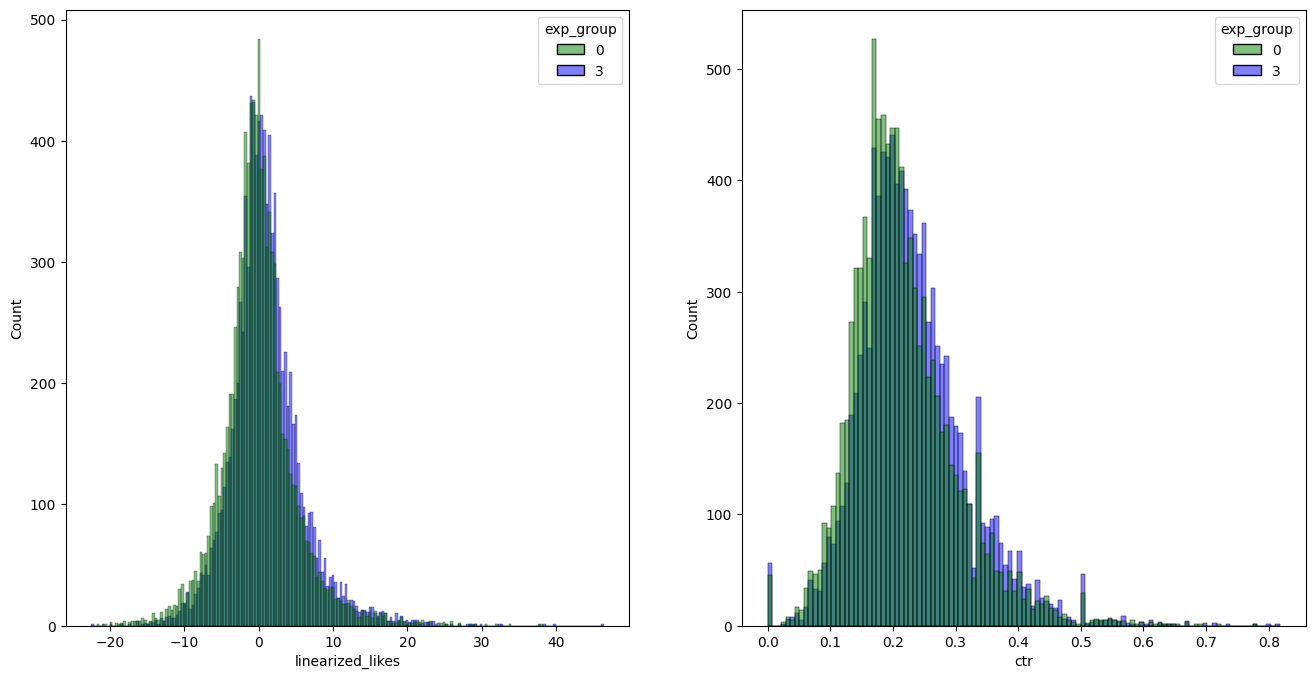

In [46]:
f, axs = plt.subplots(1,2, figsize=(16,8))
sns.histplot(df_copy[(df_copy['exp_group']==0)|(df_copy['exp_group']==3)], x='linearized_likes', hue='exp_group', palette=['g','b'], ax=axs[0])
sns.histplot(df_copy[(df_copy['exp_group']==0)|(df_copy['exp_group']==3)], x='ctr', hue='exp_group', palette=['g','b'], ax=axs[1])

Форма распределения метрик примерно одинаковая, близко к нормальной, но в 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠 отсутствуют выбросы, 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠 более сглаженная.

###  t-тест Стьюдента

H0 - значимых различий метрик в группах нет;  
H1 - значимые различия между группами есть.

In [47]:
alpha = 0.05
results = stats.ttest_ind(linearized_likes_0, 
                          linearized_likes_3, 
                          equal_var=False)
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")
    
    

p-значение: 5.4914249479690016e-52
Отвергаем нулевую гипотезу


Тест увидел изменения

In [48]:
results = stats.ttest_ind(df_copy[df_copy['exp_group']==0].ctr, 
                          df_copy[df_copy['exp_group']==3].ctr, 
                          equal_var=False)

print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

p-значение: 1.0558494146618654e-43
Отвергаем нулевую гипотезу


## Вывод 

тесты по обеим метрикам показали значимые различия между контрольной и экспериментальной группами.p-value по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠 стало меньше по сравнению с метрикой CTR.

## Тест между группами 2(тестовая) и 1(контрольная)

In [49]:
# общий CTR в контрольной группе
ctr_control = df_copy[df_copy['exp_group']==1].likes.sum() / df_copy[df_copy['exp_group']==1].views.sum()


In [50]:
# поюзерная метрика для обеих групп
linearized_likes_1 = df_copy[df_copy['exp_group']==1].likes - ctr_control * df_copy[df_copy['exp_group']==1].views
linearized_likes_2 = df_copy[df_copy['exp_group']==2].likes - ctr_control * df_copy[df_copy['exp_group']==2].views
# linearized likes
df_copy.loc[df_copy['exp_group']==1, 'linearized_likes'] = linearized_likes_1
df_copy.loc[df_copy['exp_group']==2, 'linearized_likes'] = linearized_likes_2

<AxesSubplot:xlabel='ctr', ylabel='Count'>

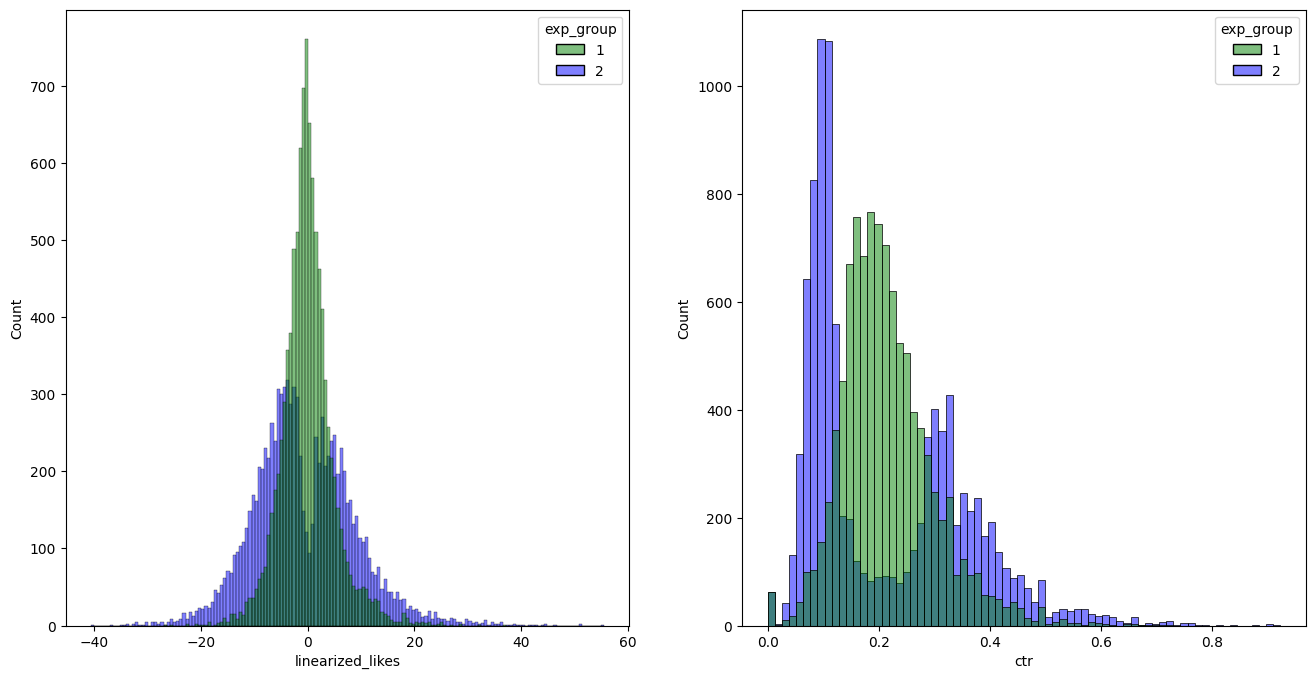

In [51]:
f, axs = plt.subplots(1,2, figsize=(16,8))
sns.histplot(df_copy[(df_copy['exp_group']==1)|(df_copy['exp_group']==2)], x='linearized_likes', hue='exp_group', palette=['g','b'], ax=axs[0])
sns.histplot(df_copy[(df_copy['exp_group']==1)|(df_copy['exp_group']==2)], x='ctr', hue='exp_group', palette=['g','b'], ax=axs[1])

Форма распределения метрик разная, у linearized likes близко к нормальной, также в 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠 сглажены выбросы.

###  t-тест Стьюдента

H0 - значимых различий метрик в группах нет;  
H1 - значимые различия между группами есть.

In [54]:
alpha = 0.05
results = stats.ttest_ind(linearized_likes_1, 
                          linearized_likes_2, 
                          equal_var=False)
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

p-значение: 9.439432187037712e-10
Отвергаем нулевую гипотезу


In [55]:
results = stats.ttest_ind(df_copy[df_copy['exp_group']==1].ctr, 
                          df_copy[df_copy['exp_group']==2].ctr, 
                          equal_var=False)

print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

p-значение: 0.4780623130874935
Не отвергаем нулевую гипотезу


## Вывод 

𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠 более чувствительная метрика, p-value меньше на десять порядков. Тест по метрике ctr не заметил отличий, в то время как по 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠 заетил.